# Реализация метода анализа тестов над метриками-отношениями

In [63]:
import pandas as pd
import pandahouse as ph
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных из Clickhouse и их предварительная обработка

In [64]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20231220'
}

In [65]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-11-18' and '2023-11-24'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df_group_12 = ph.read_clickhouse(q, connection=connection)

In [66]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-11-18' and '2023-11-24'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df_group_03 = ph.read_clickhouse(q, connection=connection)

## Функция расчета метрики линеаризованных лайков

In [67]:
def linear_likes (df, control_group):
    # Подсчет общего CTR в контрольной группе
    ctr_control=sum(df[df['exp_group']==control_group]['likes'])/sum(df[df['exp_group']==control_group]['views'])
    # Расчет поюзерной метрики линеаризованных лаков (linearized_likes=likes-CTRcontrol*views) и запись в датафрейм
    df['lin_likes']=df['likes']-ctr_control*df['views']
    return df

## Анализ теста между группами 0 и 3

In [68]:
# 0 - контрольная группа
# 3 - тестовая группа

df_group_03=linear_likes(df_group_03, 0)

**t-test по ctr**

In [69]:
t_ctr_03 = stats.ttest_ind(df_group_03[df_group_03.exp_group==0].ctr,
               df_group_03[df_group_03.exp_group==3].ctr,
               equal_var=False)
print('p-value =', t_ctr_03[1])

p-value = 6.216047483062228e-44


**t-test по linearized_likes**

In [70]:
t_lin_likes_03 = stats.ttest_ind(df_group_03[df_group_03.exp_group==0].lin_likes,
               df_group_03[df_group_03.exp_group==3].lin_likes,
               equal_var=False)
print('p-value =', t_lin_likes_03[1])

p-value = 1.4918137745326139e-58


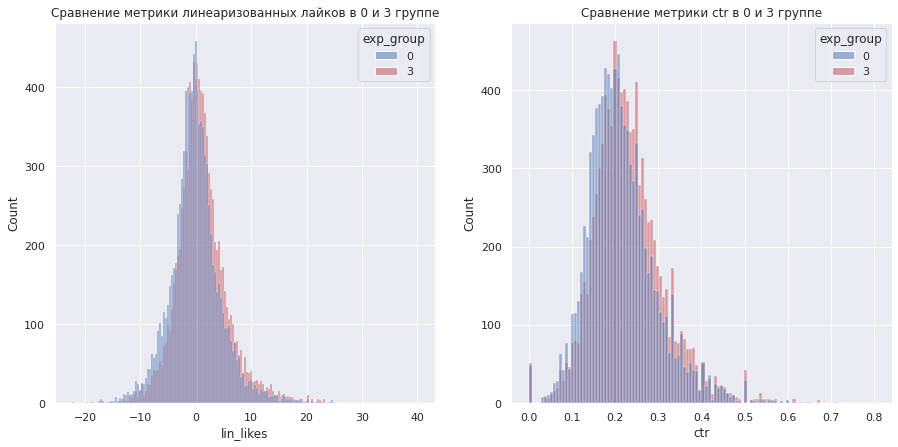

In [71]:
# График распределения метрики линеаризованных лайков в группах 0 и 3
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
groups_03_lin = sns.histplot(data = df_group_03, 
              x='lin_likes', 
              hue='exp_group', 
              palette = ['b', 'r'],
              alpha=0.5,
              kde=False, ax=axes[0])
axes[0].set_title("Сравнение метрики линеаризованных лайков в 0 и 3 группе")

# График распределения CTR в группах 0 и 3
groups_03_ctr = sns.histplot(data = df_group_03, 
              x='ctr', 
              hue='exp_group', 
              palette = ['b', 'r'],
              alpha=0.5,
              kde=False, ax=axes[1])
axes[1].set_title("Сравнение метрики ctr в 0 и 3 группе")
plt.show()

T-тест по метрике линеаризованных лайков показал статистически значимые отличия в двух группах p-value = 1.4918137745326139e-58, значит отличия есть и в исходной метрике ctr. P-value стало меньше (на 14 порядков) по сравнению с обычным ctr, где t-тест показал p-value = 6.216047483062228e-44, а значит увеличили чувствительность метрики. \
<br>
Если посмотреть на графики сравнения метрики линеаризованных лайков и сравнения ctr, то видно, что график линеаризованные лайков более сглажен и различия между группами прослеживаются лучше, чем на графике ctr.

## Анализ теста между группами 1 и 2 

In [72]:
# 1 - контрольная группа
# 2 - тестовая группа

df_group_12=linear_likes(df_group_12, 1)

**t-test по ctr**

In [73]:
t_ctr_12 = stats.ttest_ind(df_group_12[df_group_12.exp_group==1].ctr,
               df_group_12[df_group_12.exp_group==2].ctr,
               equal_var=False)
print('p-value =', t_ctr_12[1])

p-value = 0.685373331140751


**t-test по linearized_likes**

In [74]:
t_lin_likes_12 = stats.ttest_ind(df_group_12[df_group_12.exp_group==1].lin_likes,
               df_group_12[df_group_12.exp_group==2].lin_likes,
               equal_var=False)
print('p-value =', t_lin_likes_12[1])

p-value = 2.9805064038667945e-09


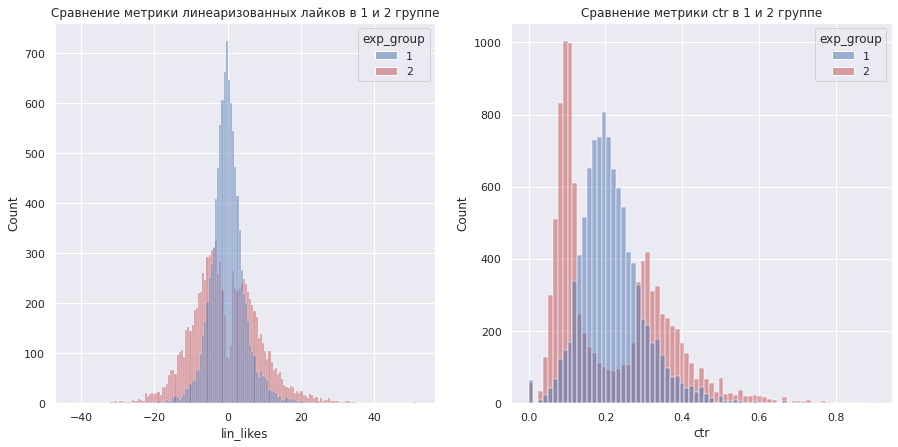

In [75]:
# График распределения метрики линеаризованных лайков в группах 1 и 2
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
groups_12_lin = sns.histplot(data = df_group_12, 
              x='lin_likes', 
              hue='exp_group', 
              palette = ['b', 'r'],
              alpha=0.5,
              kde=False, ax=axes[0])
axes[0].set_title("Сравнение метрики линеаризованных лайков в 1 и 2 группе")

# График распределения CTR в группах 1 и 2
groups_12_ctr = sns.histplot(data = df_group_12, 
              x='ctr', 
              hue='exp_group', 
              palette = ['b', 'r'],
              alpha=0.5,
              kde=False, ax=axes[1])
axes[1].set_title("Сравнение метрики ctr в 1 и 2 группе")
plt.show()

T-тест по метрике линеаризованных лайков показал статистически значимые отличия в двух группах p-value = 2.9805064038667945e-09, значит отличия есть и в исходной метрике ctr. P-value стало меньше (на 8 порядков) по сравнению с обычным ctr, где t-тест показал p-value = 0.685373331140751, из чего можно было сделать ложноотрицательный вывод, о том, что в группах нет статистически значимых отличий метрики ctr. Благодаря метрике линеаризованных лайков удалось избежать ошибки второго рода и увеличилась чувствительность метрики ctr. \
<br>
Если посмотреть на графики сравнения метрики линеаризованных лайков и сравнения ctr, то видно, что график линеаризованные лайков не имеет перекоса в левую сторону и значения влево и вправо распределены почти равномерно. Что нельзя сказать о распределении ctr, где ctr тестовой группы перекошен в левую сторону относительно графика ctr контрольной группы и имеет большой разброс значений в правую сторону. На первом графике оба распределения почти имеют нормальную форму, за исключением того, что распределение линеаризованных лайков по-преженему имеет 2 моды. Но даже в этом случае t-тест будет работать более корректно.